In [20]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [145]:
OD = np.random.randint(100,10000, (1000, 1000, 9,2))
thresh = 200

## Building the data

Let's use the following conventions:
age groups (as in paper):
    - 0 to 9
    - 10 to 19
    - 20 to 29
    - 30 to 39
    - 40 to 49
    - 50 to 59
    - 60 to 69
    - 70 to 79
    - 80+
and further compartementalize according to sex.

All rates are therefore given as 2D arrays of shape (9, 2) where the first axis is the age group and the second the gender.

In [147]:
OD = OD.sum(axis=3).sum(axis=2)

In [153]:
OD = np.random.randint(100,10000, (3, 3))

In [154]:
OD

array([[ 326, 4746,  374],
       [3582, 9335, 8973],
       [1276,  876, 8626]])

In [155]:
np.diagonal(OD)

array([ 326, 9335, 8626])

In [156]:
OD.sum(axis=0)

array([ 5184, 14957, 17973])

In [157]:
OD.sum(axis=1)

array([ 5446, 21890, 10778])

In [150]:
# initialize the population vector from the origin-destination flow matrix
N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
locs_len = len(N_k)                      # number of locations
SIR = np.zeros(shape=(locs_len, 9, 2, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
SIR[:,:,:,0] = N_k                      # initialize the S group with the respective populations

ValueError: could not broadcast input array from shape (1000) into shape (1000,9,2)

In [152]:
SIR.shape

(1000, 9, 2, 3)

In [128]:
locs_len.shape

(9, 2)

In [7]:
first_infections = np.where(SIR[:, 0]<=thresh, SIR[:, 0]//20, 0)   # for demo purposes, randomly introduce infections
SIR[:, 0] = SIR[:, 0] - first_infections
SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

In [8]:
# row normalize the SIR matrix for keeping track of group proportions
row_sums = SIR.sum(axis=1)
SIR_n = SIR / row_sums[:, np.newaxis]

### initialize parameters

In [119]:
beta = np.full((9,2), 0.16)
gamma = np.full((9,2), 0.04)
public_trans = 0.5         # alpha
R0 = beta/gamma
beta_vec = np.random.gamma(beta, 1/gamma, locs_len)
gamma_vec = np.full(locs_len, gamma)
public_trans_vec = np.full(locs_len, public_trans)

In [116]:
# make copy of the SIR matrices 
SIR_sim = SIR.copy()
SIR_nsim = SIR_n.copy()

In [117]:
# run model
print(SIR_sim.sum(axis=0).sum() == N_k.sum())
infected_pop_norm = []
susceptible_pop_norm = []
recovered_pop_norm = []
for time_step in tqdm.tqdm_notebook(range(100)):
  infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
  OD_infected = np.round(OD*infected_mat)
  inflow_infected = OD_infected.sum(axis=0)
  inflow_infected = np.round(inflow_infected*public_trans_vec)
  print('total infected inflow: ', inflow_infected.sum())
  new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
  new_recovered = gamma_vec*SIR_sim[:, 1]
  new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
  SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
  SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
  SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
  SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
  # recompute the normalized SIR matrix
  row_sums = SIR_sim.sum(axis=1)
  SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
  S = SIR_sim[:,0].sum()/N_k.sum()
  I = SIR_sim[:,1].sum()/N_k.sum()
  R = SIR_sim[:,2].sum()/N_k.sum()
  print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
  print('\n')
  infected_pop_norm.append(I)
  susceptible_pop_norm.append(S)
  recovered_pop_norm.append(R)

True


<ipython-input-117-de1afcd48c3d>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for time_step in tqdm.tqdm_notebook(range(100)):


total infected inflow:  25360.0
0.9999774171947439 2.2582410488362012e-05 3.947677755367798e-10 101325393.0 101325393


total infected inflow:  31782.0
0.9999491360655018 4.996024331073932e-05 9.036911873100172e-07 101325392.99999999 101325393


total infected inflow:  43174.0
0.9999107618420388 8.633605704144872e-05 2.90210091973959e-06 101325392.99999999 101325393


total infected inflow:  59092.0
0.9998583894476019 0.00013525500919687726 6.355543201397539e-06 101325393.00000003 101325393


total infected inflow:  81333.0
0.9997863724919696 0.00020186176446118965 1.176574356927263e-05 101325393.0 101325393


total infected inflow:  112083.0
0.9996872500263656 0.00029290975948673636 1.9840214147720217e-05 101325393.0 101325393


total infected inflow:  154746.0
0.9995505852053762 0.000417858190096652 3.1556604527189674e-05 101325393.0 101325393


total infected inflow:  213382.0
0.9993623453441991 0.0005893837236699409 4.8270932131055756e-05 101325393.0 101325393


total infected infl

total infected inflow:  40445650.0
0.6086715467444057 0.07674085135228549 0.31458760190330887 101325393.0 101325393


total infected inflow:  39318120.0
0.6077930285772155 0.07454973546538413 0.3176572359574003 101325393.0 101325393


total infected inflow:  38216816.0
0.6069481764460036 0.07241259817798064 0.3206392253760157 101325393.0 101325393


total infected inflow:  37141631.0
0.6061354827439099 0.07032878795295514 0.3235357293031349 101325393.0 101325393


total infected inflow:  36092207.0
0.6053535188516053 0.06829760032714173 0.3263488808212531 101325393.0 101325393


total infected inflow:  35068355.0
0.6046009353077262 0.06631827985793506 0.3290807848343388 101325393.0 101325393


total infected inflow:  34069716.0
0.6038764552177559 0.06439002875358796 0.33173351602865614 101325393.0 101325393


total infected inflow:  33095987.0
0.6031788690891038 0.06251201373209642 0.33430911717879974 101325393.0 101325393


total infected inflow:  32146828.0
0.6025070283719725 0.06068

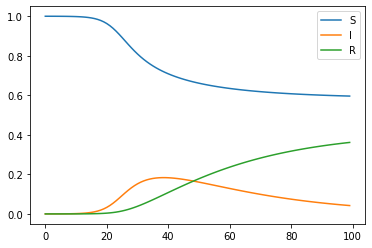

In [118]:
plt.plot(susceptible_pop_norm, label='S')
plt.plot(infected_pop_norm, label='I')
plt.plot(recovered_pop_norm, label='R')
plt.legend()